**Problem Statement:**
- You are working for a new-age insurance company and employ multiple outreach plans to sell term insurance to your customers. Telephonic marketing campaigns still remain one of the most effective way to reach out to people however they incur a lot of cost. Hence, it is important to identify the customers that are most likely to convert beforehand so that they can be specifically targeted via call. We are given the historical marketing data of the insurance company and are required to build a ML model that will predict if a client will subscribe to the insurance.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('/content/Customer Conversion Prediction - Customer Conversion Prediction.csv')
data

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no


# **DATA UNDERSTANDING & CLEANING**

In [7]:
data.shape

(45211, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital         45211 non-null  object
 3   education_qual  45211 non-null  object
 4   call_type       45211 non-null  object
 5   day             45211 non-null  int64 
 6   mon             45211 non-null  object
 7   dur             45211 non-null  int64 
 8   num_calls       45211 non-null  int64 
 9   prev_outcome    45211 non-null  object
 10  y               45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [9]:
data.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y'],
      dtype='object')

In [10]:
data_cat = data.select_dtypes(include = 'object')
data_cat = data_cat.columns.tolist()
print('Categorical :', data_cat, '\n')

data_num = data.select_dtypes(exclude= 'object')
data_num = data_num.columns.tolist()
print('Numerical :', data_num)

#y is a target (classification)

Categorical : ['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome', 'y'] 

Numerical : ['age', 'day', 'dur', 'num_calls']


In [11]:
for i in data_cat:
  print(f'{i}',data[i].unique(), '\n')

job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital ['married' 'single' 'divorced'] 

education_qual ['tertiary' 'secondary' 'unknown' 'primary'] 

call_type ['unknown' 'cellular' 'telephone'] 

mon ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

prev_outcome ['unknown' 'failure' 'other' 'success'] 

y ['no' 'yes'] 



In [12]:
# dropping the duplicated rows
print('Data shape :', data.shape)

data.drop_duplicates(inplace = True)
print('Data shape after dropping duplicates :', data.shape)

Data shape : (45211, 11)
Data shape after dropping duplicates : (45205, 11)


- **Target (Y):**

In [13]:
data['y'].isna().sum()

0

In [14]:
# data['y'].unique()

In [15]:
data['y'].value_counts()

no     39916
yes     5289
Name: y, dtype: int64

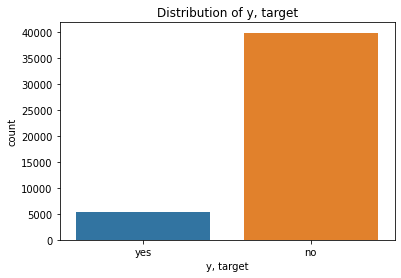

In [16]:
sns.countplot(x = data['y'],
              order = data['y'].value_counts(ascending = True).index)
plt.xlabel('y, target')
plt.title('Distribution of y, target')
plt.show()

- **Since, more than 70% of target data is 'no', it is an imbalanced learning problem.** 
- **So, we will use 'Cluster-Centroid Undersampling' or 'SMOTE Oversampling'. (else. 'SMOTEEN').**

In [17]:
# creating new dataset with target only 'yes' (people turned)
data_yes = data.loc[(data['y'] == 'yes')]
data_yes

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
83,59,admin.,married,secondary,unknown,5,may,1042,1,unknown,yes
86,56,admin.,married,secondary,unknown,5,may,1467,1,unknown,yes
87,41,technician,married,secondary,unknown,5,may,1389,1,unknown,yes
129,55,services,married,secondary,unknown,5,may,579,1,unknown,yes
168,54,admin.,married,tertiary,unknown,5,may,673,2,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...
45204,73,retired,married,secondary,cellular,17,nov,300,1,failure,yes
45205,25,technician,single,secondary,cellular,17,nov,386,2,unknown,yes
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes


## **Categorical Variables**

- **Type of Job**

In [18]:
data['job'].isna().sum()

0

In [19]:
data['job'].value_counts()

blue-collar      9730
management       9457
technician       7596
admin.           5170
services         4153
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [20]:
j = {'admin.':'admin'}
data['job'] = data['job'].replace(j)

In [22]:
data.shape

(45205, 11)

In [23]:
# data['job'].value_counts()

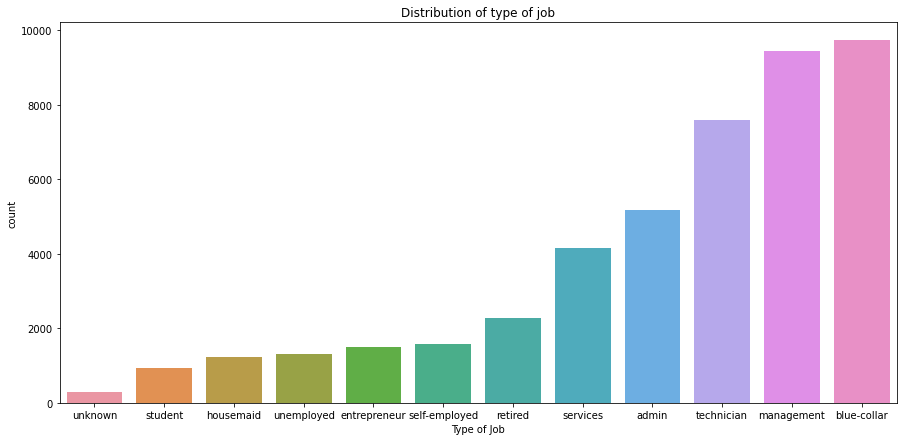

In [24]:
plt.figure(figsize = (15, 7))
sns.countplot(x = 'job', data=data,
                order = data['job'].value_counts(ascending = True).index)
plt.xlabel('Type of Job')
plt.title(f'Distribution of type of job')
plt.show()

In [25]:
# Contigency table
pd.crosstab(index=data['job'], columns=data['y'])

y,no,yes
job,,
admin,4539,631
blue-collar,9022,708
entrepreneur,1364,123
housemaid,1131,109
management,8156,1301
retired,1748,516
self-employed,1392,187
services,3784,369
student,669,269


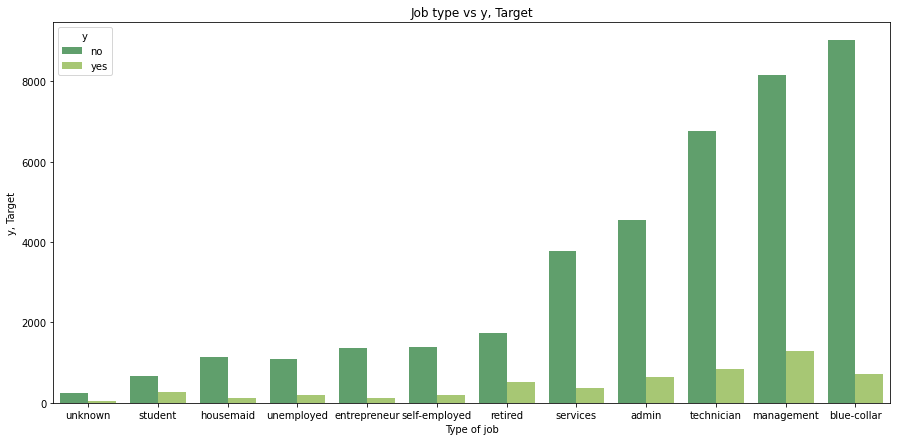

In [26]:
plt.figure(figsize = (15, 7))
sns.countplot(data = data, x = 'job', hue = 'y',palette ='summer',
              order = data['job'].value_counts(ascending = True).index)
plt.xlabel('Type of job')
plt.ylabel('y, Target')
plt.title('Job type vs y, Target')
plt.show()

In [27]:
data['y_encoded'] = data['y'].map({'yes':1, 'no':0})

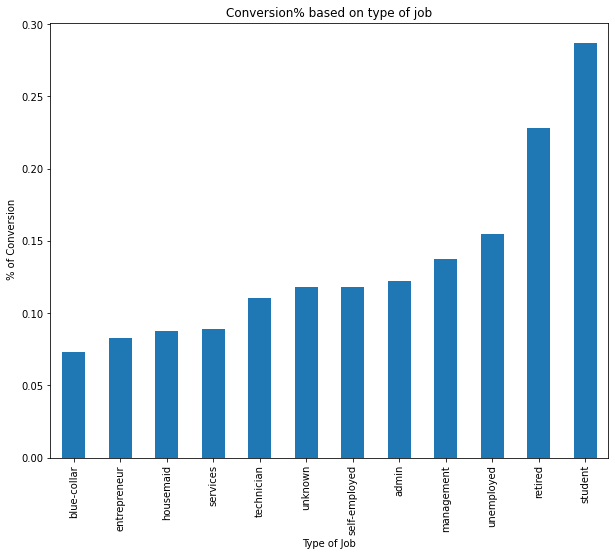

In [28]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('job')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Type of Job')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on type of job')
plt.show()

In [29]:
data2 = data.copy()

j = {'blue-collar':0, 'entrepreneur':1, 'housemaid':2, 'services':3, 'technician': 4, 'unknown':5, 'self-employed':6, 'admin':7, 'management':8, 'unemployed':9, 'retired':10, 'student':11}
data2['job'] = data['job'].map(j)

In [30]:
data2.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,married,tertiary,unknown,5,may,261,1,unknown,no,0
1,44,4,single,secondary,unknown,5,may,151,1,unknown,no,0
2,33,1,married,secondary,unknown,5,may,76,1,unknown,no,0
3,47,0,married,unknown,unknown,5,may,92,1,unknown,no,0
4,33,5,single,unknown,unknown,5,may,198,1,unknown,no,0


- **Marital status**

In [31]:
data['marital'].isna().sum()

0

In [32]:
data['marital'].value_counts()

married     27210
single      12788
divorced     5207
Name: marital, dtype: int64

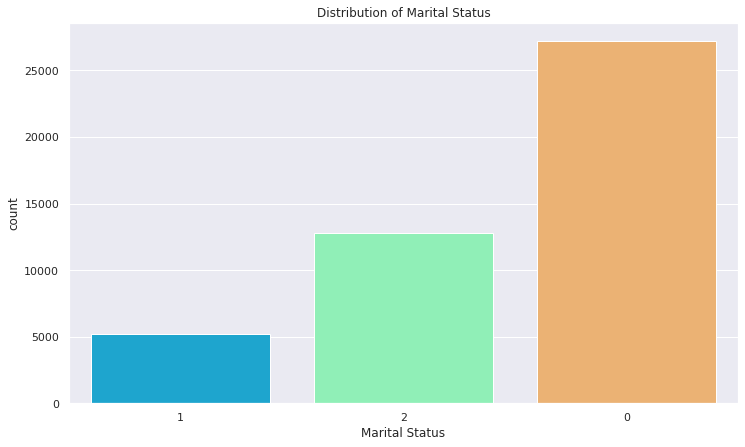

In [146]:
data['marital'].value_counts()
sns.countplot(x = 'marital', data=data,palette = 'rainbow',
                order = data['marital'].value_counts(ascending = True).index)
plt.xlabel('Marital Status')
plt.title(f'Distribution of Marital Status')
plt.show()

In [34]:
# Contigency table
pd.crosstab(index=data['marital'], columns=data['y'])

y,no,yes
marital,,
divorced,4585,622
married,24455,2755
single,10876,1912


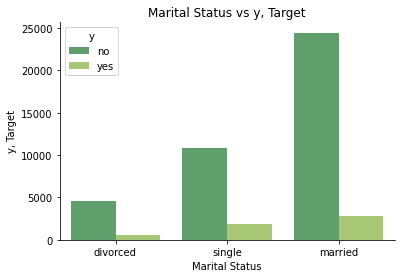

In [35]:
sns.countplot(data = data, x = 'marital', hue = 'y',palette ='summer',
              order = data['marital'].value_counts(ascending = True).index)
plt.xlabel('Marital Status')
plt.ylabel('y, Target')
plt.title('Marital Status vs y, Target')
sns.despine()
plt.show()

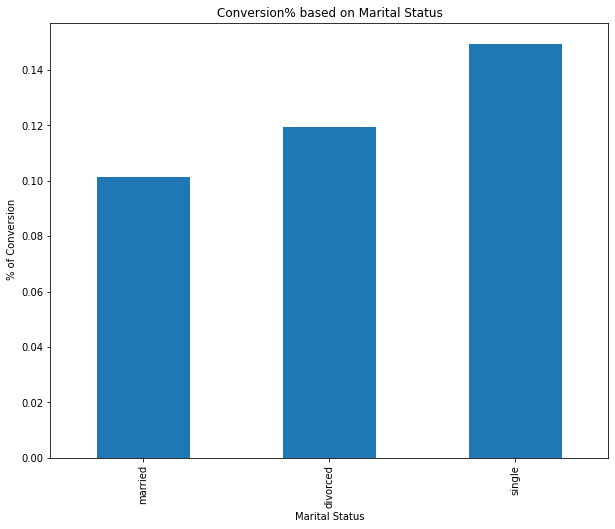

In [36]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('marital')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Marital Status')
plt.show()

In [37]:
m = {'married':0, 'divorced':1, 'single':2}
data2['marital'] = data['marital'].map(m)

data2.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,tertiary,unknown,5,may,261,1,unknown,no,0
1,44,4,2,secondary,unknown,5,may,151,1,unknown,no,0
2,33,1,0,secondary,unknown,5,may,76,1,unknown,no,0


- **Educational Qualification**

In [38]:
data['education_qual'].isna().sum()

0

In [39]:
data['education_qual'].value_counts()

secondary    23199
tertiary     13299
primary       6850
unknown       1857
Name: education_qual, dtype: int64

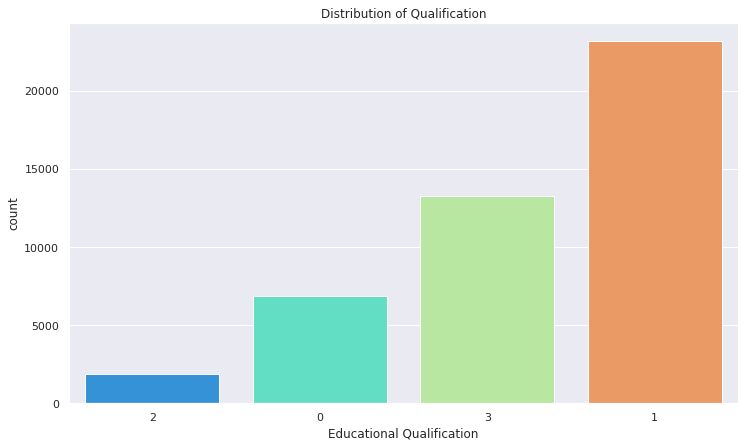

In [145]:
sns.countplot(x = 'education_qual', data=data, palette = 'rainbow',
                order = data['education_qual'].value_counts(ascending = True).index)
plt.xlabel('Educational Qualification')
plt.title(f'Distribution of Qualification')
plt.show()

In [41]:
# Contigency table
pd.crosstab(index=data['education_qual'], columns=data['y'])

y,no,yes
education_qual,,
primary,6259,591
secondary,20749,2450
tertiary,11303,1996
unknown,1605,252


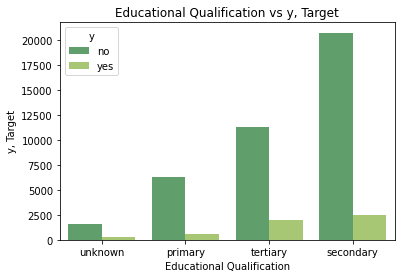

In [42]:
sns.countplot(data = data, x = 'education_qual', hue = 'y', palette ='summer',
              order = data['education_qual'].value_counts(ascending = True).index)
plt.xlabel('Educational Qualification')
plt.ylabel('y, Target')
plt.title('Educational Qualification vs y, Target')
plt.show()

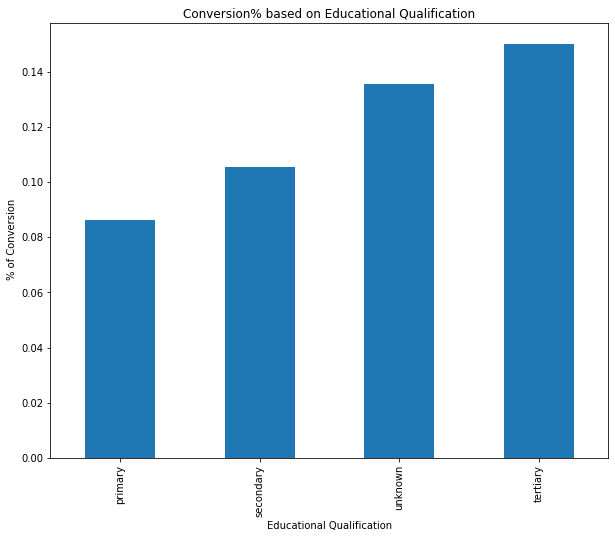

In [43]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('education_qual')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Educational Qualification')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Educational Qualification')
plt.savefig('Conversion% based on Edu Qualification.jpg')

In [44]:
e = {'primary': 0, 'secondary':1, 'unknown':2, 'tertiary':3}
data2['education_qual'] = data['education_qual'].map(e)

data2.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,3,unknown,5,may,261,1,unknown,no,0
1,44,4,2,1,unknown,5,may,151,1,unknown,no,0
2,33,1,0,1,unknown,5,may,76,1,unknown,no,0


- **Call type**

In [45]:
data['call_type'].isna().sum()

0

In [46]:
data['call_type'].value_counts()

cellular     29282
unknown      13017
telephone     2906
Name: call_type, dtype: int64

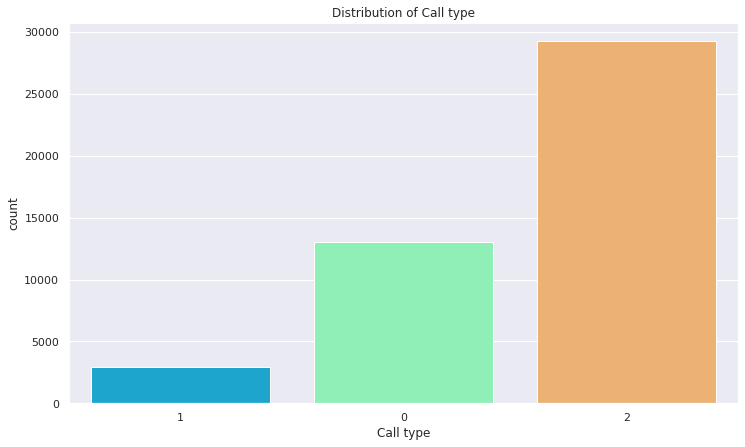

In [144]:
sns.countplot(x = 'call_type', data=data, palette = 'rainbow',
                order = data['call_type'].value_counts(ascending = True).index)
plt.xlabel('Call type')
plt.title(f'Distribution of Call type')
plt.show()

In [48]:
# Contigency table
pd.crosstab(index=data['call_type'], columns=data['y'])

y,no,yes
call_type,,
cellular,24913,4369
telephone,2516,390
unknown,12487,530


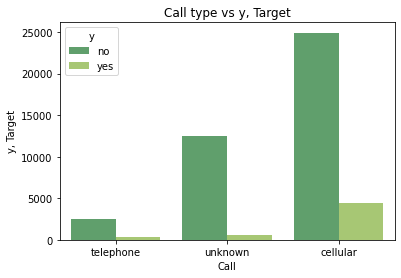

In [49]:
sns.countplot(data = data, x = 'call_type', hue = 'y',palette ='summer',
              order = data['call_type'].value_counts(ascending = True).index)
plt.xlabel('Call')
plt.ylabel('y, Target')
plt.title('Call type vs y, Target')
plt.show()

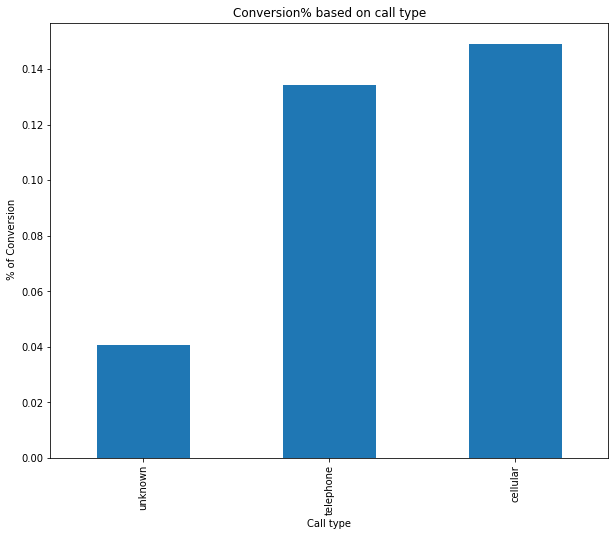

In [50]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('call_type')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Call type')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on call type')
plt.show()

In [51]:
# checking unknown job type, education qualification and call type
unknown = data.loc[((data['job'] == 'unknown') & (data['education_qual'] == 'unknown') & (data['call_type'] == 'unknown'))]
unknown.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no,0
216,47,unknown,married,unknown,unknown,5,may,338,2,unknown,no,0
354,59,unknown,divorced,unknown,unknown,5,may,347,3,unknown,no,0
876,37,unknown,single,unknown,unknown,7,may,131,1,unknown,no,0
2046,57,unknown,married,unknown,unknown,12,may,836,4,unknown,no,0


In [52]:
unknown.shape[0]

54

In [53]:
ct ={ 'unknown' :0, 'telephone' :1, 'cellular' :2}
data2['call_type'] = data['call_type'].map(ct)

data2.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,3,0,5,may,261,1,unknown,no,0
1,44,4,2,1,0,5,may,151,1,unknown,no,0
2,33,1,0,1,0,5,may,76,1,unknown,no,0


- **Month**

In [54]:
data['mon'].isna().sum()

0

In [55]:
data['mon'].value_counts()

may    13765
jul     6894
aug     6245
jun     5339
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: mon, dtype: int64

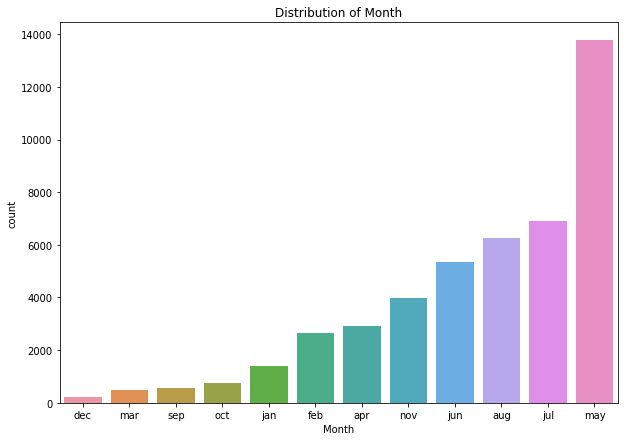

In [56]:
plt.figure(figsize = (10,7))
sns.countplot(x = 'mon', data=data,
                order = data['mon'].value_counts(ascending = True).index)
plt.xlabel('Month')
plt.title(f'Distribution of Month')
plt.show()

In [57]:
# Contigency table
pd.crosstab(index=data['mon'], columns=data['y'])

y,no,yes
mon,,
apr,2355,577
aug,5557,688
dec,114,100
feb,2208,441
jan,1261,142
jul,6267,627
jun,4793,546
mar,229,248
may,12840,925


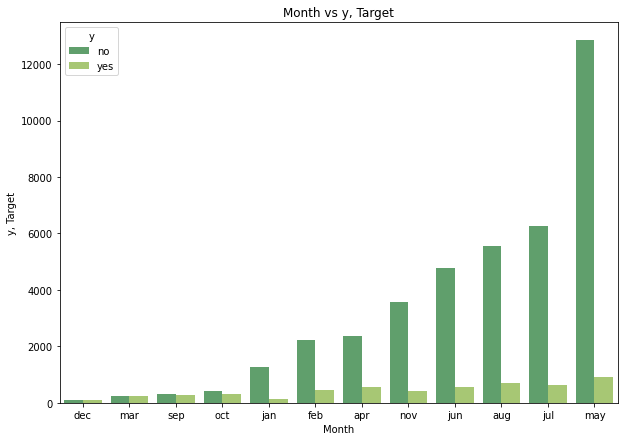

In [58]:
plt.figure(figsize = (10,7))
sns.countplot(data = data, x = 'mon', hue = 'y',palette ='summer',
              order = data['mon'].value_counts(ascending = True).index)
plt.xlabel('Month')
plt.ylabel('y, Target')
plt.title('Month vs y, Target')
plt.show()

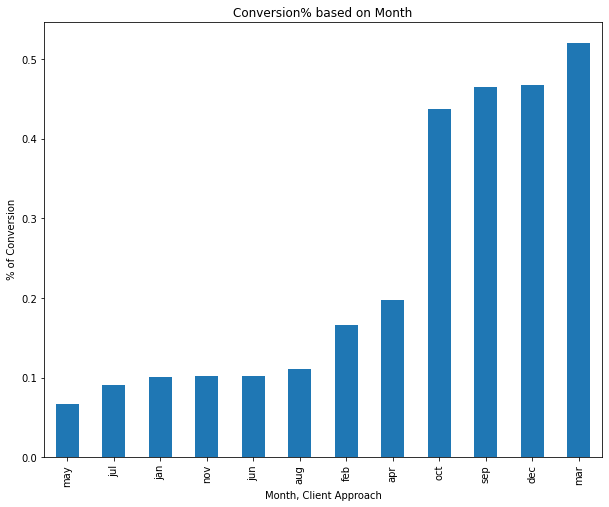

In [59]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('mon')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Month, Client Approach')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Month')
plt.show()

In [60]:
month ={'may':0, 'jul':1, 'jan':2, 'nov':3, 'jun':4, 'aug':5, 'feb':6, 'apr':7, 'oct':8, 'sep':9, 'dec':10, 'mar':11}
data2['mon'] = data['mon'].map(month)

data2.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,3,0,5,0,261,1,unknown,no,0
1,44,4,2,1,0,5,0,151,1,unknown,no,0
2,33,1,0,1,0,5,0,76,1,unknown,no,0


- **Previous outcome**

In [61]:
data['prev_outcome'].isna().sum()

0

In [62]:
data['prev_outcome'].value_counts()

unknown    36953
failure     4901
other       1840
success     1511
Name: prev_outcome, dtype: int64

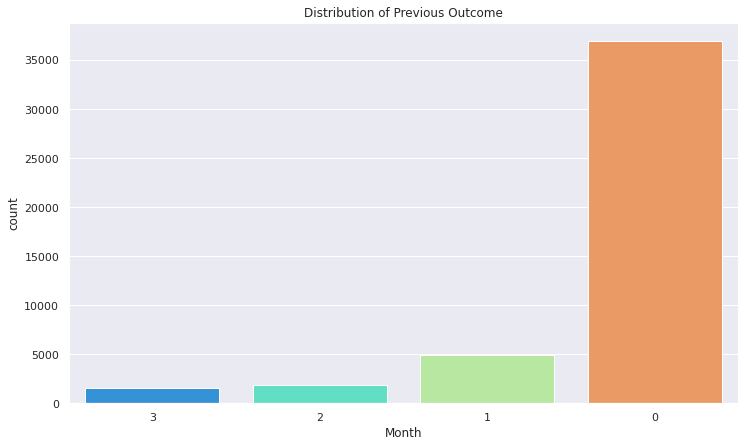

In [143]:
sns.countplot(x = 'prev_outcome', data=data, palette = 'rainbow',
                order = data['prev_outcome'].value_counts(ascending = True).index)
plt.xlabel('Month')
plt.title(f'Distribution of Previous Outcome')
plt.show()

In [64]:
# Contigency table
pd.crosstab(index=data['prev_outcome'], columns=data['y'])

y,no,yes
prev_outcome,,
failure,4283,618
other,1533,307
success,533,978
unknown,33567,3386


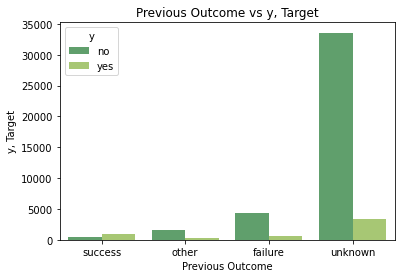

In [65]:
sns.countplot(data = data, x = 'prev_outcome', hue = 'y',palette ='summer',
              order = data['prev_outcome'].value_counts(ascending = True).index)
plt.xlabel('Previous Outcome')
plt.ylabel('y, Target')
plt.title('Previous Outcome vs y, Target')
plt.show()

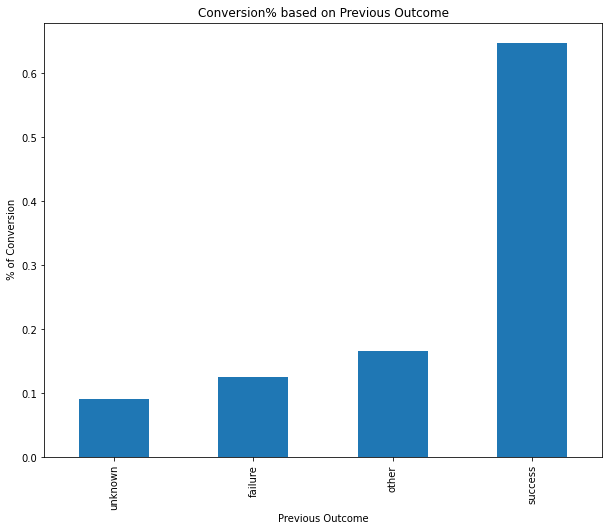

In [66]:
# EDA
plt.figure(figsize=(10,8))
data.groupby('prev_outcome')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Previous Outcome')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Previous Outcome')
plt.show()

In [67]:
prev = {'unknown':0, 'failure':1, 'other':2, 'success':3}
data2['prev_outcome'] = data['prev_outcome'].map(prev)

data2.head(3)

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,3,0,5,0,261,1,0,no,0
1,44,4,2,1,0,5,0,151,1,0,no,0
2,33,1,0,1,0,5,0,76,1,0,no,0


In [68]:
data2['prev_outcome'].unique()

array([0, 1, 2, 3])

In [69]:
# checking unknown job type, education qualification and call type
unknown4 = data.loc[((data['job'] == 'unknown') & (data['education_qual'] == 'unknown') & (data['call_type'] == 'unknown') & (data['prev_outcome'] == 'unknown'))]
unknown4.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no,0
216,47,unknown,married,unknown,unknown,5,may,338,2,unknown,no,0
354,59,unknown,divorced,unknown,unknown,5,may,347,3,unknown,no,0
876,37,unknown,single,unknown,unknown,7,may,131,1,unknown,no,0
2046,57,unknown,married,unknown,unknown,12,may,836,4,unknown,no,0


In [70]:
unknown4.shape[0]

54

**y conversion for Chi2**

**Feature Selection through Chi-Squared test**

In [71]:
data_cat

['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome', 'y']

In [72]:
from sklearn.feature_selection import chi2

x = data2[['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome']]
y = data2['y_encoded']

In [73]:
chi_scores, p_values = chi2(x,y)

In [74]:
# p-values for categorical features
p_values

array([0.00000000e+000, 1.10280046e-050, 8.62968870e-042, 2.27295944e-130,
       0.00000000e+000, 0.00000000e+000])

In [75]:
p_values = pd.Series(p_values, index = x.columns)
p_values.sort_values(ascending = False , inplace = True)

Text(0.5, 1.0, 'Chi2 test')

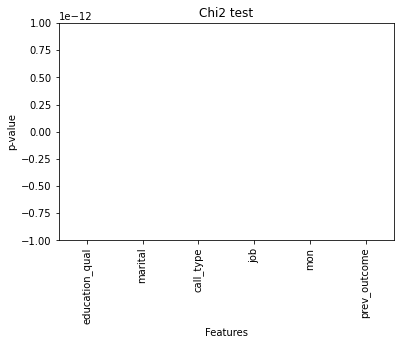

In [76]:
p_values.plot.bar()
plt.xlabel('Features')
plt.ylabel('p-value')
plt.title('Chi2 test')

- **Since, all the categorical features have lower the p-values (<0.05), we can consider all the features for model building.**

## **Numerical Variables**

In [77]:
data_num

['age', 'day', 'dur', 'num_calls']

In [78]:
data[['age', 'day', 'dur', 'num_calls']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45205 entries, 0 to 45210
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45205 non-null  int64
 1   day        45205 non-null  int64
 2   dur        45205 non-null  int64
 3   num_calls  45205 non-null  int64
dtypes: int64(4)
memory usage: 2.7 MB


- No null values or missing values.
- All the features are in integer.

In [79]:
data.describe()

,age,day,dur,num_calls,y_encoded
count,45205.000000,45205.00000,45205.000000,45205.000000,45205.000000
mean,40.937087,15.80688,258.183055,2.763898,0.117000
std,10.619130,8.32234,257.538504,3.098189,0.321424
min,18.000000,1.00000,0.000000,1.000000,0.000000
25%,33.000000,8.00000,103.000000,1.000000,0.000000
50%,39.000000,16.00000,180.000000,2.000000,0.000000
75%,48.000000,21.00000,319.000000,3.000000,0.000000
max,95.000000,31.00000,4918.000000,63.000000,1.000000


- **Outlier detection**

- - **Age**

IQR of age: 15.0
Upper Limit : 70.5  Lower Limit : 10.5 



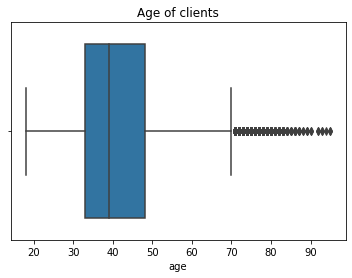

In [80]:
# Outliers - Age:

Q3, Q1 = np.percentile(data['age'], [75,25])

IQR = Q3 - Q1
print('IQR of age:', IQR)

# Upper Limit and Lower Limit Threshold
UL = Q3 + (1.5 * IQR)
LL = Q1 - (1.5 * IQR)

print('Upper Limit :', UL, ' Lower Limit :', LL, '\n')

sns.boxplot(x = data['age'])
plt.title('Age of clients')
plt.show()

- The minimum age can't be 10 or 11 it will be 18 as per insurance policy and maximum age limit 65 years in most cases. 

In [81]:
data.loc[((data['age']>70) | (data['age']<18))]

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
29158,83,retired,married,primary,telephone,2,feb,912,1,unknown,no,0
29261,75,retired,divorced,primary,cellular,2,feb,294,1,unknown,no,0
29263,75,retired,married,primary,cellular,2,feb,149,1,unknown,no,0
29322,83,retired,married,tertiary,cellular,2,feb,283,2,unknown,no,0
29865,75,retired,divorced,primary,cellular,4,feb,136,3,unknown,yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...
45163,71,retired,married,secondary,cellular,9,nov,379,2,failure,no,0
45191,75,retired,divorced,tertiary,cellular,16,nov,262,1,failure,yes,1
45204,73,retired,married,secondary,cellular,17,nov,300,1,failure,yes,1
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes,1


- Around 487 people got the term insurance, >70 years. 
- Since, minimum age is 18 children couldn't be contacted.

- - **Day**

IQR of day: 13.0
Upper Limit : 40.5  Lower Limit : -11.5 



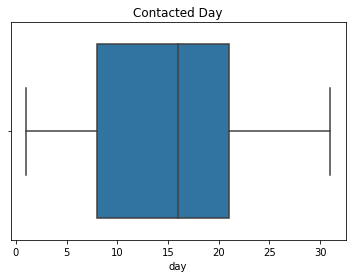

In [82]:
# Outliers - Day:

Q3, Q1 = np.percentile(data['day'], [75,25])

IQR = Q3 - Q1
print('IQR of day:', IQR)

# Upper Limit and Lower Limit Threshold
UL = Q3 + (1.5 * IQR)
LL = Q1 - (1.5 * IQR)

print('Upper Limit :', UL, ' Lower Limit :', LL, '\n')

sns.boxplot(x = data['day'])
plt.title('Contacted Day')
plt.show()

**There are no outliers in day column.**

- - **Duration of Calls**

IQR of dur: 216.0
Upper Limit : 643.0  Lower Limit : -221.0 



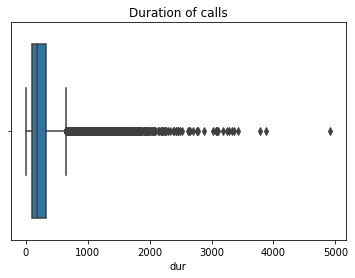

In [83]:
# Outliers - Duration:

Q3, Q1 = np.percentile(data['dur'], [75,25])

IQR = Q3 - Q1
print('IQR of dur:', IQR)

# Upper Limit and Lower Limit Threshold
UL = Q3 + (1.5 * IQR)
LL = Q1 - (1.5 * IQR)

print('Upper Limit :', UL, ' Lower Limit :', LL, '\n')

sns.boxplot(x = data['dur'])
plt.title('Duration of calls')
plt.show()

In [84]:
# outliers based on duration of calls
data.loc[((data['dur']>UL) | (data['dur']<LL))]

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
37,53,technician,married,secondary,unknown,5,may,1666,1,unknown,no,0
43,54,retired,married,secondary,unknown,5,may,1492,1,unknown,no,0
53,42,admin,single,secondary,unknown,5,may,787,1,unknown,no,0
59,46,services,married,primary,unknown,5,may,1778,1,unknown,no,0
61,53,technician,divorced,secondary,unknown,5,may,812,1,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
45124,27,blue-collar,single,primary,cellular,26,oct,701,2,unknown,yes,1
45199,34,blue-collar,single,secondary,cellular,16,nov,1166,3,other,no,0
45200,38,technician,married,secondary,cellular,16,nov,1556,4,unknown,yes,1
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes,1


In [85]:
Q75, Q82_5, Q90, Q98 = np.percentile(data['dur'], [75, 82.5,90, 98])

print('Q75 :', Q75)
print('Q82.5 :', Q82_5)
print('Q90 :', Q90)
print('Q95 :', Q98)

Q75 : 319.0
Q82.5 : 399.0
Q90 : 548.0
Q95 : 1051.0


- - **Number of Calls**

IQR of num_calls: 2.0
Upper Limit : 6.0  Lower Limit : -2.0 



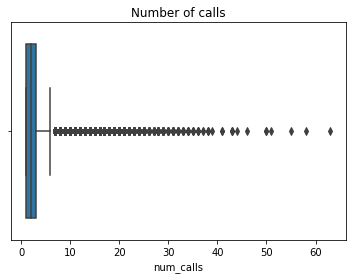

In [88]:
# Outliers - Previous calls:

Q3, Q1 = np.percentile(data['num_calls'], [75,25])

IQR = Q3 - Q1
print('IQR of num_calls:', IQR)

# Upper Limit and Lower Limit Threshold
UL = Q3 + (1.5 * IQR)
LL = Q1 - (1.5 * IQR)

print('Upper Limit :', UL, ' Lower Limit :', LL, '\n')

sns.boxplot(x = data['num_calls'])
plt.title('Number of calls')
plt.show()

In [89]:
# outliers based on number of calls
data.loc[((data['num_calls']>UL) | (data['num_calls']<LL))]

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
758,59,services,married,secondary,unknown,6,may,250,7,unknown,no,0
780,30,admin,married,secondary,unknown,7,may,172,8,unknown,no,0
906,27,services,single,secondary,unknown,7,may,388,7,unknown,no,0
1103,52,technician,married,unknown,unknown,7,may,253,8,unknown,no,0
1105,43,admin,married,tertiary,unknown,7,may,244,7,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44666,25,technician,single,secondary,cellular,2,sep,206,7,other,no,0
44680,27,self-employed,single,tertiary,telephone,3,sep,543,9,failure,no,0
44770,37,services,single,tertiary,cellular,13,sep,323,9,other,yes,1
44886,38,management,married,tertiary,cellular,24,sep,246,12,failure,no,0


In [90]:
Q80, Q85, Q90 = np.percentile(data['num_calls'], [80, 85, 90])

print('Q80:', Q80)
print('Q85 :', Q85)
print('Q90 :', Q90)

Q80: 4.0
Q85 : 4.0
Q90 : 5.0


### **Distribution of Numerical Features:**

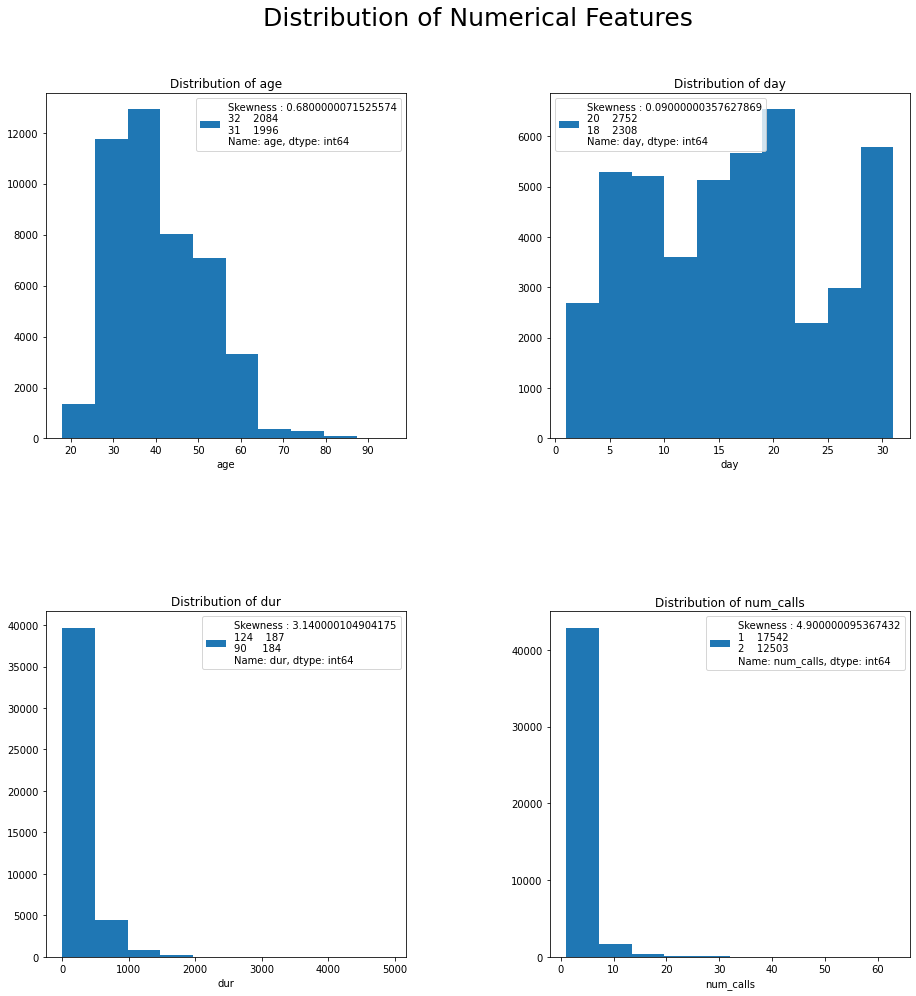

In [91]:
j = 0
plt.figure(figsize = (15,15))
plt.suptitle('Distribution of Numerical Features', fontsize=25)

for i in data_num:
  plt.subplot(2,2,j+1)
  skew = data[i].skew(axis=0).astype(np.float32).round(2)
  plt.hist(data[i], label = 'Skewness : {}\n{}'.format(skew,data[i].value_counts().head(2)))
  plt.xlabel(i)
  plt.legend()
  plt.title('Distribution of {}'.format(i))
  j += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)
plt.show()

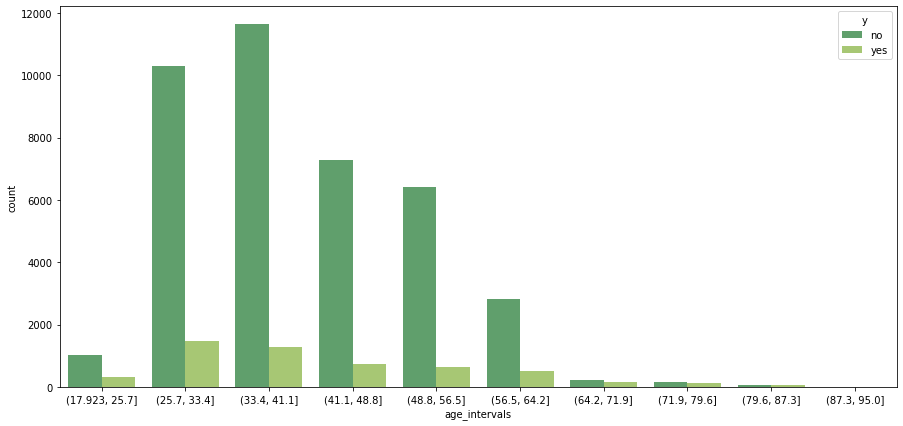

In [93]:
data3 = data.copy()
data3['age_intervals'] = pd.cut(data3['age'], bins=10, right = True)

plt.figure(figsize = (15,7))
ax = sns.countplot(data = data3, x = 'age_intervals', hue = 'y',palette ='summer')
plt.show()

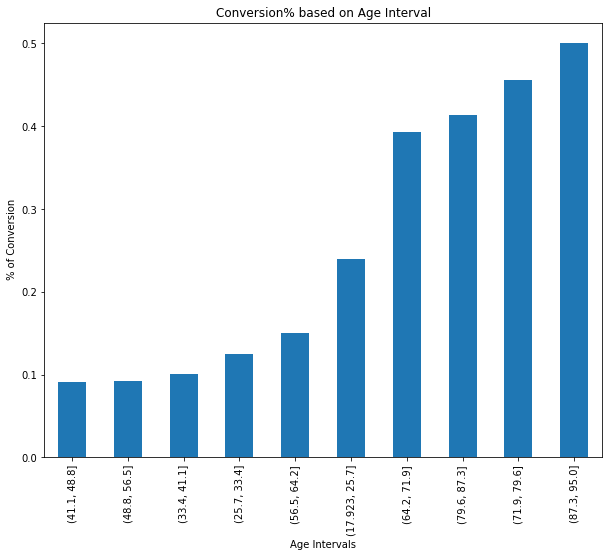

In [94]:
# EDA
plt.figure(figsize=(10,8))
data3.groupby('age_intervals')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Age Intervals')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Age Interval')
plt.show()

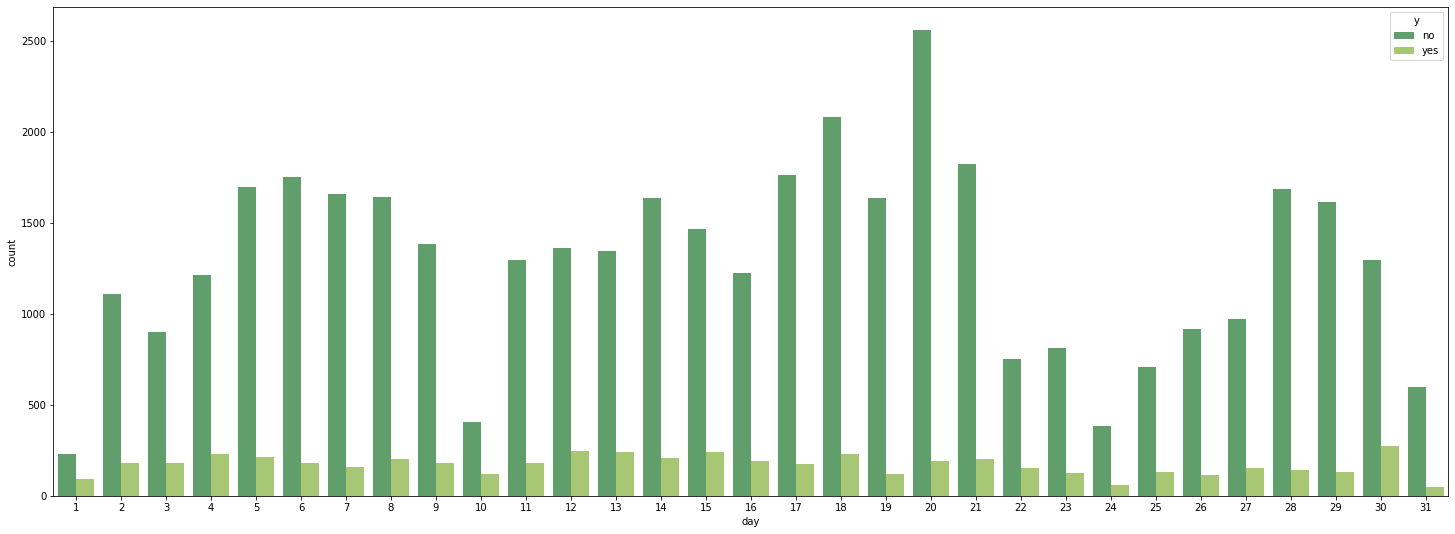

In [95]:
plt.figure(figsize = (25,9))
ax = sns.countplot(data = data3, x = 'day', hue = 'y',palette ='summer')
plt.show()

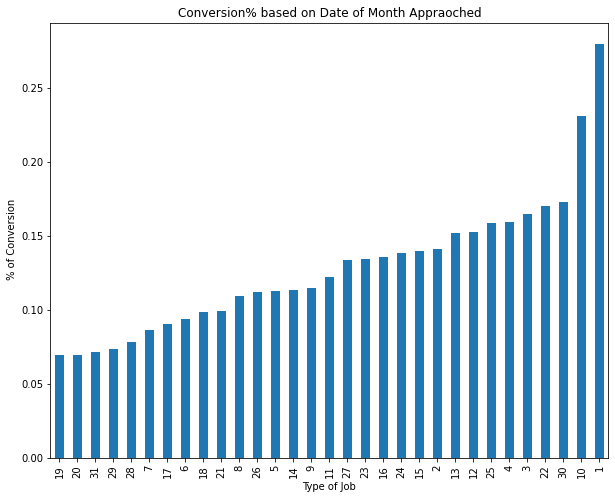

In [96]:
# EDA
plt.figure(figsize=(10,8))
data3.groupby('day')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Type of Job')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Date of Month Appraoched')
plt.show()

**There is linearity between the feature and the target, except at its peak. We can go for Logistic Regression with feature.**

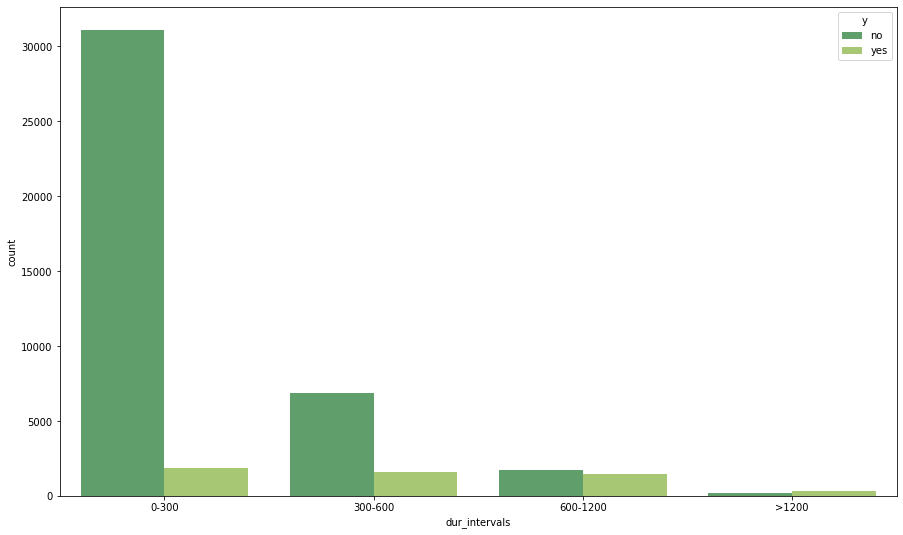

In [97]:
data3["dur_intervals"] = pd.cut(data3['dur'], [0, 300, 600, 1200, np.inf], labels=['0-300', '300-600', '600-1200', '>1200'])
plt.figure(figsize = (15,9))
ax = sns.countplot(data = data3, x = 'dur_intervals', hue = 'y',palette ='summer')
plt.show()

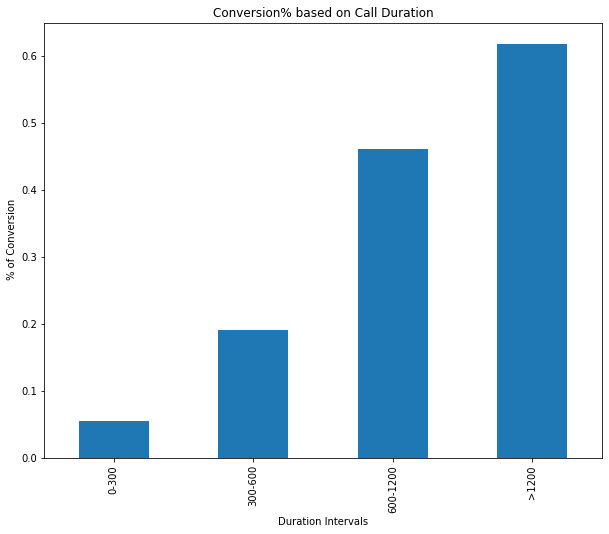

In [98]:
# EDA
plt.figure(figsize=(10,8))
data3.groupby('dur_intervals')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Duration Intervals')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Call Duration')
plt.show()

**Since, range responds to the conversion, there is relationship between them.**

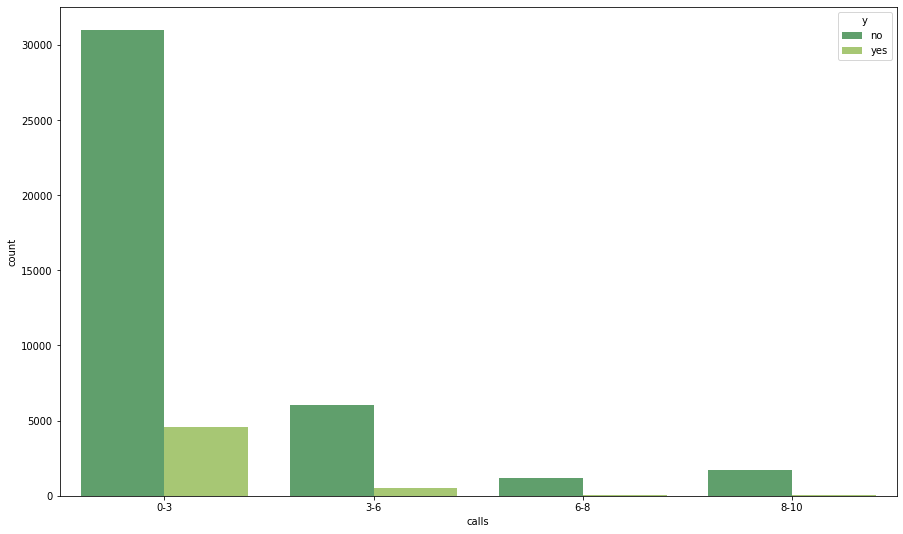

In [99]:
data3['calls'] = pd.cut(data3['num_calls'], [0, 3, 6, 8, np.inf], labels=['0-3', '3-6', '6-8', '8-10'])

plt.figure(figsize = (15,9))
ax = sns.countplot(data = data3, x = 'calls', hue = 'y',palette ='summer')
plt.show()

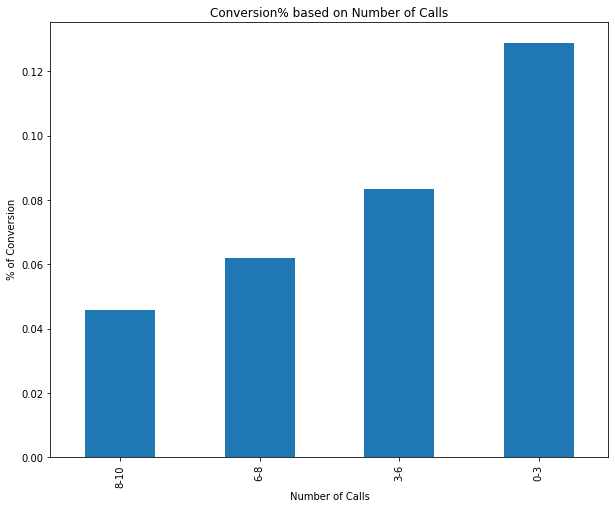

In [100]:
# EDA
plt.figure(figsize=(10,8))
data3.groupby('calls')['y_encoded'].mean().sort_values().plot(kind='bar')
plt.xlabel('Number of Calls')
plt.ylabel(' % of Conversion')
plt.title('Conversion% based on Number of Calls')
plt.show()

- **There is linearity in the data. We can go with Logistic Regression.**
- **No transformation required.**

In [101]:
data_num

['age', 'day', 'dur', 'num_calls']

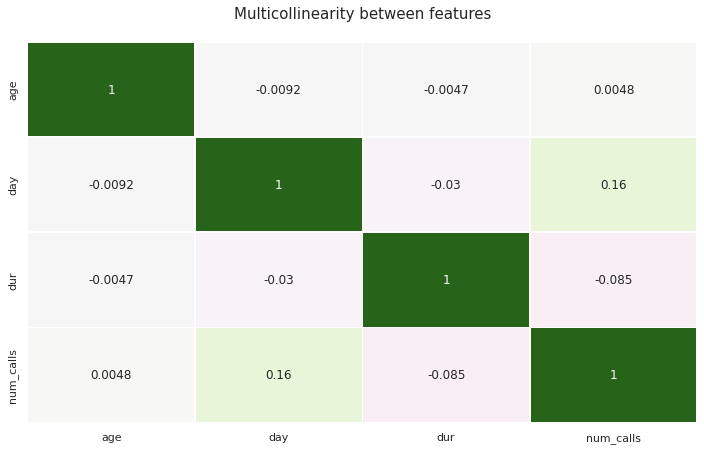

In [102]:
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(data[['age', 'day', 'dur', 'num_calls']].corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="PiYG")
plt.title('Multicollinearity between features\n', fontsize = 15)
plt.show()

# **Balancing the DATASET**

In [103]:
!pip install imblearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
data = data2
data.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y,y_encoded
0,58,8,0,3,0,5,0,261,1,0,no,0
1,44,4,2,1,0,5,0,151,1,0,no,0
2,33,1,0,1,0,5,0,76,1,0,no,0
3,47,0,0,2,0,5,0,92,1,0,no,0
4,33,5,2,2,0,5,0,198,1,0,no,0


In [105]:
data['y'] = data['y_encoded']
data.drop(columns = ['y_encoded'], axis = 1, inplace = True)
data.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,8,0,3,0,5,0,261,1,0,0
1,44,4,2,1,0,5,0,151,1,0,0
2,33,1,0,1,0,5,0,76,1,0,0
3,47,0,0,2,0,5,0,92,1,0,0
4,33,5,2,2,0,5,0,198,1,0,0


In [106]:
X = data.iloc[:, :-1].values
y = data.loc[:, 'y'].values

In [107]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [108]:
# scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train, y_train) # find mean and standard deviation

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

- **Synthetic Minority - Oversampling**

In [109]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [110]:
X_sm.shape, y_sm.shape

((59922, 10), (59922,))

In [111]:
y_sm, X_sm

X_sm = pd.DataFrame(X_sm)
y_sm = pd.Series(y_sm)

X_sm, y_sm

(              0         1         2         3         4         5         6  \
 0     -0.747678 -1.396480 -0.770342 -0.447606 -1.518979 -1.541226  0.413590   
 1      0.288139  0.671201 -0.770342 -0.447606  0.711190  1.823045 -0.687725   
 2     -0.559347  0.966584 -0.770342  1.429350  0.711190 -1.060616  0.780695   
 3     -0.936008 -0.214948 -0.770342  1.429350  0.711190  0.621520  0.046485   
 4     -1.218503 -1.101097 -0.770342  1.429350  0.711190 -0.099395 -1.054830   
 ...         ...       ...       ...       ...       ...       ...       ...   
 59917 -1.638820 -0.155533  1.489394 -0.447606  0.711190  0.765841  2.224500   
 59918 -1.064512  1.046532  1.489394 -0.447606  0.711190 -1.333441 -0.938213   
 59919 -0.739429 -1.396480  1.489394 -1.386084  0.711190 -0.339700 -1.054830   
 59920  1.599889 -0.209801 -0.770342 -0.447606  0.711190 -0.698064  1.147800   
 59921  1.330112  0.671201 -0.770342  0.460196  0.711190 -0.843875  1.502905   
 
               7         8         9  

- **Oversampling followed by Undersampling**

In [112]:
from imblearn.combine import SMOTEENN
smt = SMOTEENN()
X_sn, y_sn = smt.fit_resample(X_train, y_train)

In [113]:
X_sn.shape, y_sn.shape

((53367, 10), (53367,))

In [114]:
X_sn = pd.DataFrame(X_sn)
y_sn = pd.DataFrame(y_sn)

# **ML Models**

## **1. Logistic Regression**

- **SMOTE**

Accuracy : 0.825 
f1-score : 0.525 
AUROC : 0.819


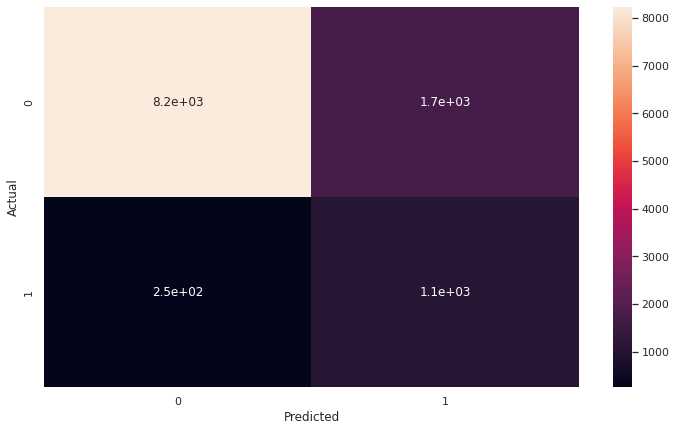

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

def LR(X, y):
  logistic = LogisticRegression()
  logistic.fit(X, y)

  y_pred = logistic.predict(X_test)
  print('Accuracy :', logistic.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)

LR(X_sm, y_sm)

- **SMOTEENN**

Accuracy : 0.789 
f1-score : 0.495 
AUROC : 0.822


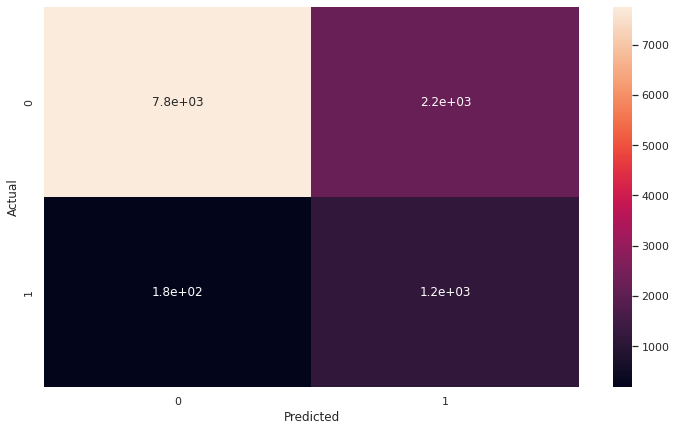

In [116]:
LR(X_sn, y_sn)

## **2. KNN Classification**

- **SMOTE**

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

K = []

for i in [1,2,3,4,5,6,7,8,9,10,15,20,30]: # looping to find best K
    knn = KNeighborsClassifier(i) #initialising the model
    knn.fit(X_sm,y_sm) # training the model

    K.append({'K Value' : i, 'Cross_val_Score': np.mean(cross_val_score(knn, X_sm, y_sm, cv = j)).round(5)})
    score = pd.DataFrame(K, columns = ['K Value', 'Cross_val_Score'])

score.sort_values(by = 'Cross_val_Score', ascending = False).head()

,K Value,Cross_val_Score
1,2,0.94339
0,1,0.94284
3,4,0.92974
2,3,0.92679
5,6,0.91898


DISTANCE at p = 1:
Accuracy : 0.872 
f1-score : 0.48 
AUROC : 0.709


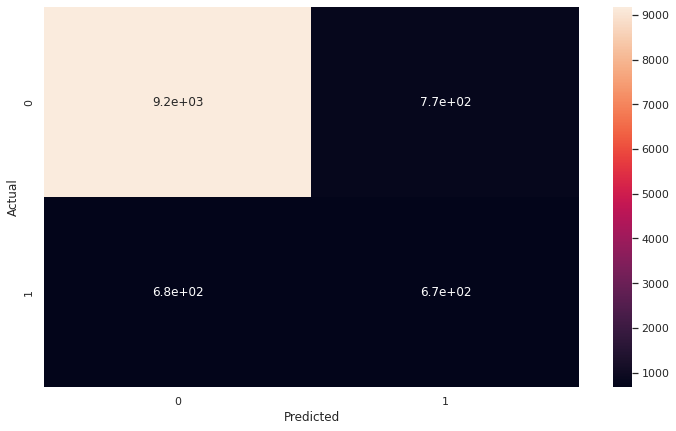

In [118]:
def KNN(K, w, p):
  knn = KNeighborsClassifier(n_neighbors = K, weights = w, p = p)
  knn.fit(X_sm,y_sm)

  y_pred = knn.predict(X_test)

  print(w.upper(), f'at p = {p}:')
  print('Accuracy :', knn.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)

KNN(2, 'distance', 1)

DISTANCE at p = 2:
Accuracy : 0.862 
f1-score : 0.474 
AUROC : 0.715


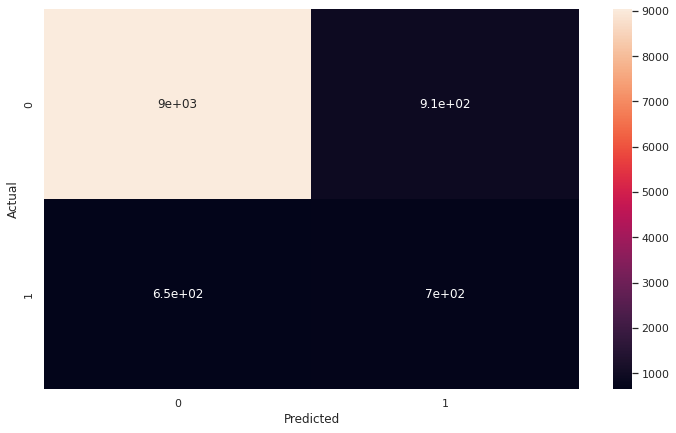

In [119]:
KNN(2, 'distance', 2)

UNIFORM at p = 1:
Accuracy : 0.879 
f1-score : 0.474 
AUROC : 0.696


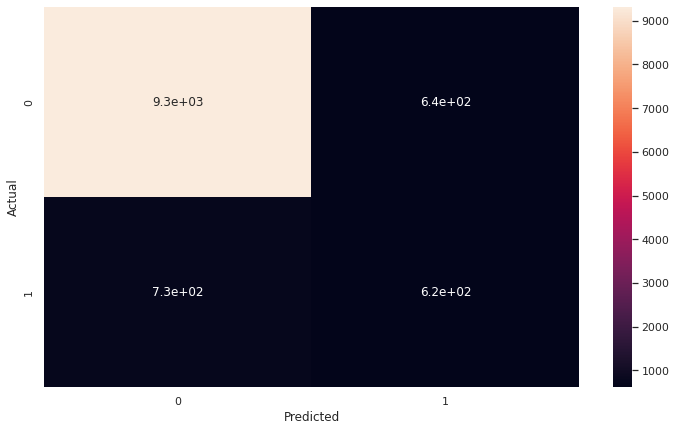

In [120]:
KNN(2, 'uniform', 1)

UNIFORM at p = 2:
Accuracy : 0.873 
f1-score : 0.476 
AUROC : 0.705


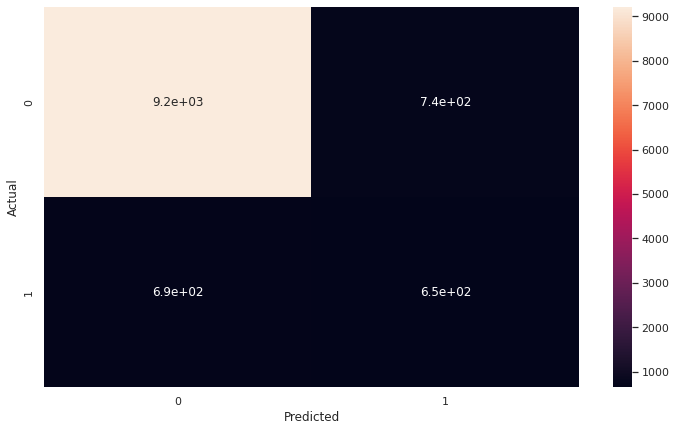

In [121]:
KNN(2, 'uniform', 2)

- **SMOTEENN**

In [122]:
K = []

for i in [1,2,3,4,5,6,7,8,9,10,15,20,30]: # looping to find best K
    knn = KNeighborsClassifier(i) #initialising the model
    knn.fit(X_sn,y_sn) # training the model

    K.append({'K Value' : i, 'Cross_val_Score': np.mean(cross_val_score(knn, X_sm, y_sm, cv = j)).round(5)})
    score = pd.DataFrame(K, columns = ['K Value', 'Cross_val_Score'])

score.sort_values(by = 'Cross_val_Score', ascending = False).head()

,K Value,Cross_val_Score
1,2,0.94339
0,1,0.94284
3,4,0.92974
2,3,0.92679
5,6,0.91898


DISTANCE at p = 1:
Accuracy : 0.872 
f1-score : 0.48 
AUROC : 0.709


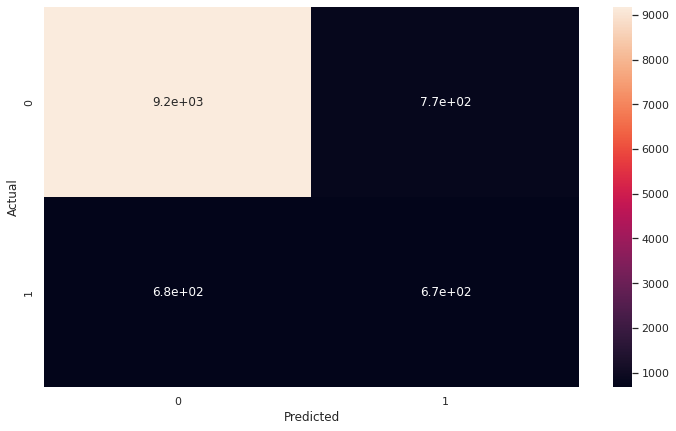

In [123]:
def KNN(K,w,p):
  knn = KNeighborsClassifier(n_neighbors=K, weights=w, p=p)
  knn.fit(X_sm,y_sm)

  y_pred = knn.predict(X_test)

  print(w.upper(), f'at p = {p}:')
  print('Accuracy :', knn.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)

KNN(2, 'distance', 1)

DISTANCE at p = 2:
Accuracy : 0.862 
f1-score : 0.474 
AUROC : 0.715


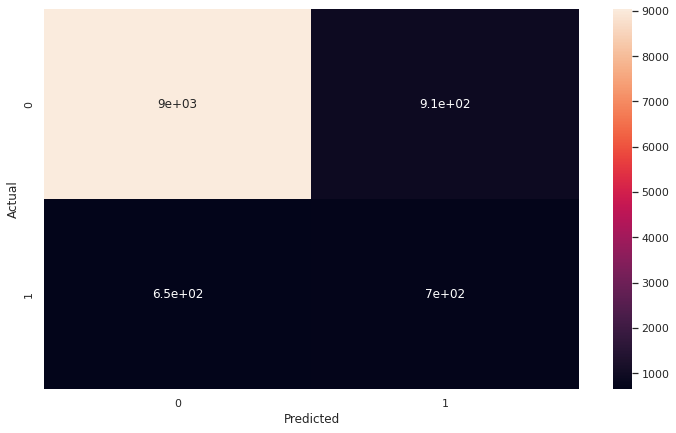

In [124]:
KNN(2, 'distance', 2)

UNIFORM at p = 1:
Accuracy : 0.879 
f1-score : 0.474 
AUROC : 0.696


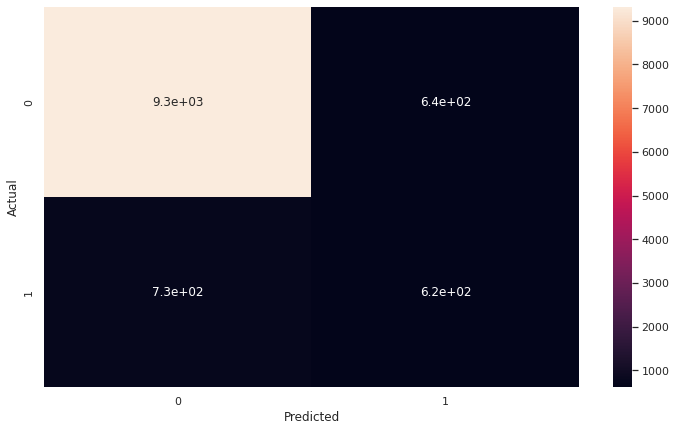

In [125]:
KNN(2, 'uniform', 1)

UNIFORM at p = 2:
Accuracy : 0.873 
f1-score : 0.476 
AUROC : 0.705


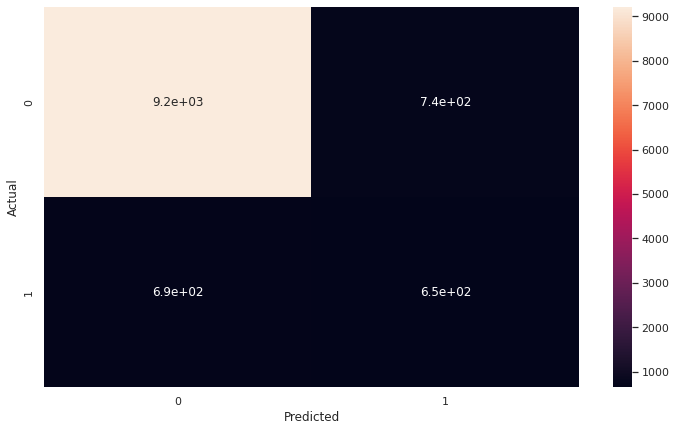

In [126]:
KNN(2, 'uniform', 2)

## **3. Decision Tree Classifier**

- **SMOTE**

In [127]:
from sklearn.tree import DecisionTreeClassifier

DT = []

for depth in [1,2,3,4,5,6,7,8,9,10,20]:
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(X_sm, y_sm)
  valAccuracy = cross_val_score(dt, X_sm, y_sm, cv=10)
  DT.append({'Depth' : depth, 'Cross_val_Score': np.mean(valAccuracy).round(5)})
  score = pd.DataFrame(DT, columns = ['Depth', 'Cross_val_Score'])

score.sort_values(by = 'Cross_val_Score', ascending = False).head()

,Depth,Cross_val_Score
10,20,0.91561
9,10,0.88517
8,9,0.87259
7,8,0.86150
6,7,0.84699


Accuracy : 0.869 
f1-score : 0.501 
AUROC : 0.733


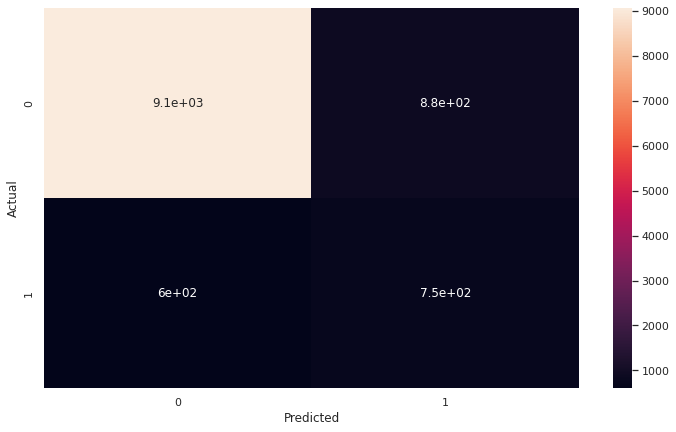

In [128]:
def DT(i):
  dt = DecisionTreeClassifier(max_depth=i)
  dt.fit(X_sm,y_sm)

  y_pred = dt.predict(X_test)

  print('Accuracy :', dt.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)

DT(20)

In [129]:
fimp = dt.feature_importances_.round(3)
List = fimp.tolist()
Fea = data.columns[:-1].tolist()

val = {
    'Feature' : Fea,
    'Importances' : List
}

Feature = pd.DataFrame(val).sort_values(by='Importances', ascending = False)
Feature

,Feature,Importances
7,dur,0.358
6,mon,0.195
5,day,0.094
4,call_type,0.085
8,num_calls,0.066
0,age,0.064
9,prev_outcome,0.063
1,job,0.045
3,education_qual,0.016
2,marital,0.015


- **SMOTEENN**

In [130]:
from sklearn.tree import DecisionTreeClassifier

DT = []

for depth in [1,2,3,4,5,6,7,8,9,10,20]:
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(X_sn, y_sn)
  valAccuracy = cross_val_score(dt, X_sm, y_sm, cv=10)
  DT.append({'Depth' : depth, 'Cross_val_Score': np.mean(valAccuracy).round(5)})
  score = pd.DataFrame(DT, columns = ['Depth', 'Cross_val_Score'])

score.sort_values(by = 'Cross_val_Score', ascending = False).head()

,Depth,Cross_val_Score
10,20,0.91619
9,10,0.88522
8,9,0.87260
7,8,0.86162
6,7,0.84697


Accuracy : 0.869 
f1-score : 0.504 
AUROC : 0.734


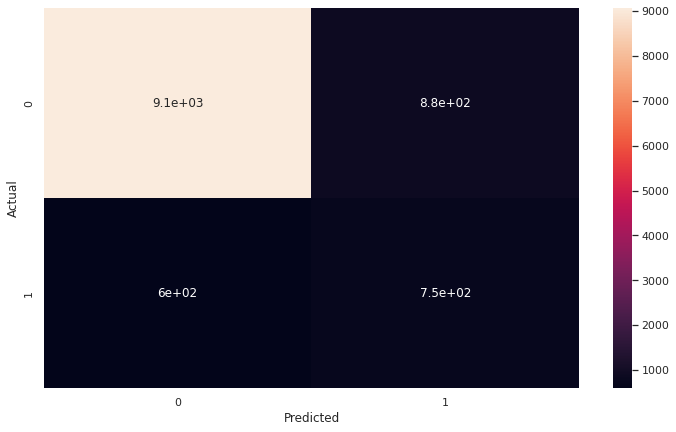

In [131]:
def DT(i):
  dt = DecisionTreeClassifier(max_depth=i)
  dt.fit(X_sm,y_sm)

  y_pred = dt.predict(X_test)

  print('Accuracy :', dt.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True)

DT(20)

In [132]:
fimp = dt.feature_importances_.round(3)
List = fimp.tolist()
Fea = data.columns[:-1].tolist()

val = {
    'Feature' : Fea,
    'Importances' : List
}

Feature = pd.DataFrame(val).sort_values(by='Importances', ascending = False)
Feature

,Feature,Importances
7,dur,0.418
6,mon,0.211
4,call_type,0.101
9,prev_outcome,0.073
5,day,0.069
0,age,0.042
1,job,0.035
8,num_calls,0.030
3,education_qual,0.014
2,marital,0.008


## **4. Random Forest Classifier**

- **SMOTE**

Accuracy : 0.853 
f1-score : 0.482 
AUROC : 0.812


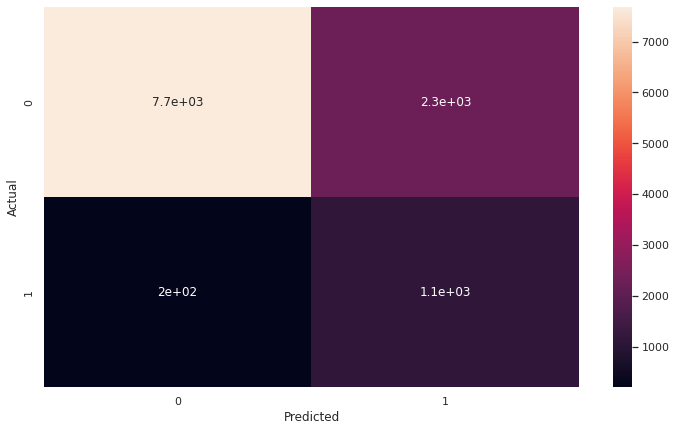

In [133]:
from sklearn.ensemble import RandomForestClassifier

depth = int(np.log(10)/np.log(2)) # log2(number of features)

rf = RandomForestClassifier(max_depth= depth, max_features = 'sqrt')
rf.fit(X_sm, y_sm)

y_pred = rf.predict(X_test)

print('Accuracy :', dt.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [134]:
fimp = rf.feature_importances_.round(3)
List = fimp.tolist()
Fea = data.columns[:-1].tolist()

val = {
    'Feature' : Fea,
    'Importances' : List
}

Feature = pd.DataFrame(val).sort_values(by='Importances', ascending = False)
Feature

,Feature,Importances
7,dur,0.466
6,mon,0.165
9,prev_outcome,0.155
4,call_type,0.097
8,num_calls,0.056
1,job,0.030
0,age,0.015
3,education_qual,0.007
2,marital,0.004
5,day,0.004


- **SMOTEENN**

Accuracy : 0.853 
f1-score : 0.432 
AUROC : 0.799


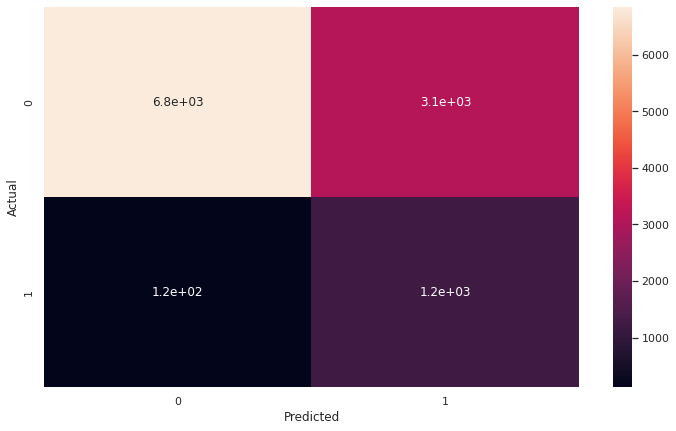

In [135]:
depth = int(np.log(10)/np.log(2)) # log2(number of features)

rf = RandomForestClassifier(max_depth= depth, max_features = 'sqrt')
rf.fit(X_sn, y_sn)

y_pred = rf.predict(X_test)

print('Accuracy :', dt.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [136]:
fimp = rf.feature_importances_.round(3)
List = fimp.tolist()
Fea = data.columns[:-1].tolist()

val = {
    'Feature' : Fea,
    'Importances' : List
}

Feature = pd.DataFrame(val).sort_values(by='Importances', ascending = False)
Feature

,Feature,Importances
7,dur,0.520
6,mon,0.162
4,call_type,0.131
9,prev_outcome,0.086
8,num_calls,0.041
1,job,0.030
0,age,0.016
3,education_qual,0.007
5,day,0.005
2,marital,0.002


## **5. XG BOOST**

In [137]:
import xgboost as xgb

XG = []

for lr in [0.01,0.05,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
  XGB = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
  XGB.fit(X_sm,y_sm) #train the model
  print("Learning rate : ", lr," Cross-Val score : ", np.mean(cross_val_score(XGB, X_sm, y_sm, cv=10)).round(4))

Learning rate :  0.01  Cross-Val score :  0.8156
Learning rate :  0.05  Cross-Val score :  0.8788
Learning rate :  0.1  Cross-Val score :  0.9036
Learning rate :  0.11  Cross-Val score :  0.9069
Learning rate :  0.12  Cross-Val score :  0.9098
Learning rate :  0.13  Cross-Val score :  0.9125
Learning rate :  0.14  Cross-Val score :  0.9149
Learning rate :  0.15  Cross-Val score :  0.9166
Learning rate :  0.2  Cross-Val score :  0.9214
Learning rate :  0.5  Cross-Val score :  0.9275
Learning rate :  0.7  Cross-Val score :  0.9293
Learning rate :  1  Cross-Val score :  0.9285


In [138]:
X_test

array([[-1.12433826,  0.96658368,  1.48939386, ..., -0.64651953,
         0.40036016, -0.41734855],
       [-0.27685167, -0.21494836, -0.77034166, ..., -0.94893504,
         4.62246288, -0.41734855],
       [-0.5593472 ,  0.96658368, -0.77034166, ..., -0.31696418,
         0.07558303, -0.41734855],
       ...,
       [-0.46518202,  0.96658368,  1.48939386, ...,  2.22642776,
        -0.2491941 , -0.41734855],
       [-0.1826865 , -1.3964804 ,  0.3595261 , ..., -0.41389222,
        -0.2491941 , -0.41734855],
       [ 1.13562597,  0.37581766, -0.77034166, ..., -0.15412506,
        -0.2491941 , -0.41734855]])

Accuracy : 0.902 
f1-score : 0.55 
AUROC : 0.729


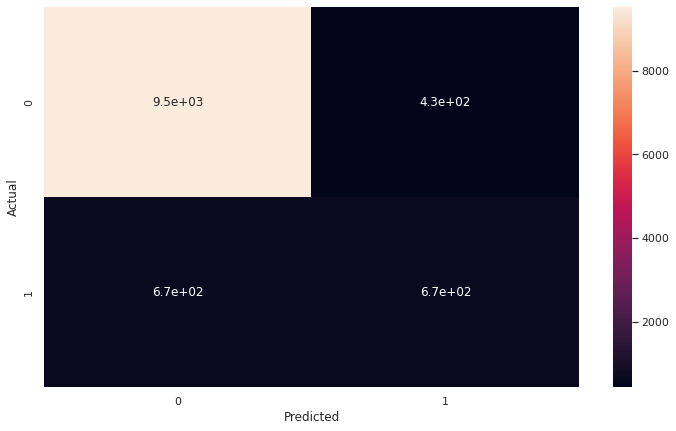

In [139]:
XGB = xgb.XGBClassifier(learning_rate = 1, n_estimators=100)
XGB.fit(X_sm,y_sm) #train the model

X_test = pd.DataFrame(X_test)
y_pred = XGB.predict(X_test)

print('Accuracy :', XGB.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [140]:
for lr in [0.01,0.05,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
  XGB = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
  XGB.fit(X_sn,y_sn) #train the model
  print("Learning rate : ", lr," Cross-Val score : ", np.mean(cross_val_score(XGB, X_sn, y_sn, cv=10)).round(4))

Learning rate :  0.01  Cross-Val score :  0.8754
Learning rate :  0.05  Cross-Val score :  0.9233
Learning rate :  0.1  Cross-Val score :  0.9422
Learning rate :  0.11  Cross-Val score :  0.9462
Learning rate :  0.12  Cross-Val score :  0.9488
Learning rate :  0.13  Cross-Val score :  0.952
Learning rate :  0.14  Cross-Val score :  0.9534
Learning rate :  0.15  Cross-Val score :  0.9559
Learning rate :  0.2  Cross-Val score :  0.9613
Learning rate :  0.5  Cross-Val score :  0.9674
Learning rate :  0.7  Cross-Val score :  0.9665
Learning rate :  1  Cross-Val score :  0.9683


Accuracy : 0.902 
f1-score : 0.55 
AUROC : 0.729


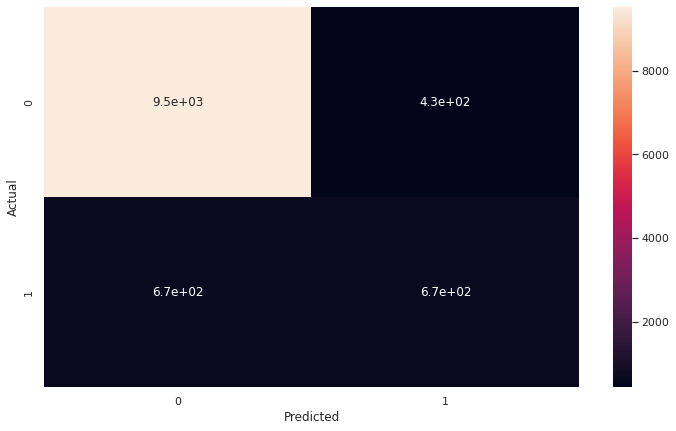

In [141]:
XGB = xgb.XGBClassifier(learning_rate = 1, n_estimators=100)
XGB.fit(X_sm,y_sm) #train the model

X_test = pd.DataFrame(X_test)
y_pred = XGB.predict(X_test)

print('Accuracy :', XGB.score(X_test,y_test).round(3),
        '\nf1-score :', f1_score(y_test, y_pred).round(3),
        '\nAUROC :', roc_auc_score(y_test, y_pred).round(3))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)